The <b>Black-Scholes</b> is a mathematical method to model the dynamics of a derivative instrument. Its formula estimates the theoretical value of European-style options and shows that the option has a unique price given the security and its expected return.

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from pandas_datareader.data import DataReader

<b>Vanilla Options</b> are financial instruments that give the holder the right, but not the obligation, to buy or sell an underlying asset at a predetermined (strike) price within a given time window. <b>European options</b> are a type of vanilla options that can be exercised at the expiry date. Such options are used by individuals or companies to hedge their exposure in a particular asset or to speculate on the price movement of a financial instrument.

The <b>Black-Scholes call option price $C$ </b>is calculated by subtracting the value of the strike price $K$ multiplied by the risk-adjusted probability that the option will be exercised $N(d_2)$, of the product of the stock price $S$ and the probability of receiving the stock at the expiration of the option contract $N(d_1)$.

$$C = SN(d_1) - K e^{-rt} N(d_2)$$

$$d_1 = \frac{ln_K^S + (r+ \frac{\sigma^2}{2} \Delta t) }{\sigma  \sqrt{\Delta t}}$$

$$d_2 = d_1 - \sigma \sqrt{\Delta t}$$

where:
1. $C$ - Call option price
2. $S$ - Current stock price (or other underlying instrument)
3. $K$ - Strike price
4. $r$ - Risk-free interest rate
5. $\Delta t$ - Time to maturity (T-t)
6. $N$ - Normal distribution
7. $\sigma$ - Volatility of the asset
8. $N(d_1)$ - Probability of receiving the stock at the expiration of our option contract. (The expected value of the receipt of the stock is contingent on the exercise of the option. It is, therefore, the product of the conditional expected value of the receipt of the stock given that exercise has occurred times the probability of exercise)
9. $N(d_2)$ - Risk-adjusted probability that the option will be exercised

Assumptions:
1. Constant volatility is assumed, although this may not be the case. Replacing this term with stochastic-process generated volatility would reduce error.
2. Returns are assumed to be normally distributed.
3. Risk-free rate is hypothetical assuming that all payment obligations are met.
4. The underlying stock does not pay dividends during the option contract. This can be adjusted by subtracting the discounted value of a future dividend from the stock price.
5. Assumes that markets function efficiently and are perfectly liquid, with the stock price moving independently and possibility to buy or sell any amount at any given time.

In [2]:
def d1(S, K, r, dt, sigma):
    return (np.log(S/K) + (r + np.sqrt(sigma) * .5 * dt)) / (sigma * np.sqrt(dt))

def d2(S, K, r, dt, sigma):
    return d1(S, K, r, dt, sigma) - sigma * np.sqrt(dt)

def call(S, K, r, dt, sigma):
    return S * norm.cdf(d1(S, K, r, dt, sigma)) - K * np.exp(-r * dt) * norm.cdf(d2(S, K, r, dt, sigma))

In the below data cell, we are querying price data for 1 year for a sample stock in our case Tesla from Yahoo Finance. And we set the risk-free rate to a 30 year U.S. treasury yield:

In [3]:
date = datetime.datetime.now()
date_m1 = date - datetime.timedelta(365)

df = DataReader('TSLA', 'yahoo', date_m1, date).sort_values('Date')
df['rel_day_returns'] = (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)
display(df)

trsry30_yield = DataReader('^TYX', 'yahoo', date - datetime.timedelta(1), date)['Close'].iloc[0]

,High,Low,Open,Close,Volume,Adj Close,rel_day_returns
Date,,,,,,,
2021-10-01,260.260010,254.529999,259.466675,258.406677,51094200.0,258.406677,NaN
2021-10-04,268.989990,258.706665,265.500000,260.510010,91449900.0,260.510010,0.008140
2021-10-05,265.769989,258.066681,261.600006,260.196655,55297800.0,260.196655,-0.001203
2021-10-06,262.220001,257.739990,258.733337,260.916656,43898400.0,260.916656,0.002767
2021-10-07,268.333344,261.126678,261.820007,264.536682,57587400.0,264.536682,0.013874
...,...,...,...,...,...,...,...
2022-09-26,284.089996,270.309998,271.829987,276.010010,58076900.0,276.010010,0.002470
2022-09-27,288.670013,277.510010,283.839996,282.940002,61925200.0,282.940002,0.025108
2022-09-28,289.000000,277.570007,283.079987,287.809998,54664800.0,287.809998,0.017212


We set our strike price to be 5% lower than the current price and an option exercise date 30 days from today. If one was purchasing this option to speculate on the price of the underlying asset, they would not want the price to drop more than 5% or rather 5% minus the option contract cost $C$. Naturally, if the price increased that would be beneficial.

In [4]:
S = df['Close'].iloc[-1]
K = S * 0.95
r = trsry30_yield / 100.
dt = 30 / 360
sigma = np.sqrt(df.index.unique().shape[0]) * df['rel_day_returns'].std()
round_dec = 4 #Display round decimals
print('Current price:', np.round(S, round_dec))
print('Strike price:', np.round(K, round_dec))
print('Risk free rate:', np.round(r, round_dec))

Current price: 265.25
Strike price: 251.9875
Risk free rate: 0.0377


In [5]:
C = call(S, K, r, dt, sigma)
print('Calculated option contract price:', np.round(C, round_dec))

Calculated option contract price: 26.3505


Parameters impacting option price:

In [6]:
expiry_time_range = range(1,361)
expiry_time_effect = [call(S, K, r, tx/360, sigma) for tx in expiry_time_range]

volatility_range = np.linspace(0, 0.7, 50)
volatility_effect = [call(S, K, r, dt, sigmax) for sigmax in volatility_range]

strike_range = range(250, 291)
strike_effect = [call(S, Kx, r, dt, sigma) for Kx in strike_range]

underlying_price_range = range(250, 291)
underlying_price_effect = [call(Sx, K, r, dt, sigma) for Sx in underlying_price_range]

<ipython-input-2-f5ebf365f591>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.log(S/K) + (r + np.sqrt(sigma) * .5 * dt)) / (sigma * np.sqrt(dt))


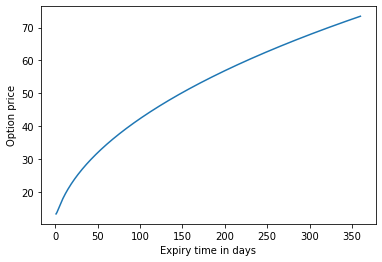

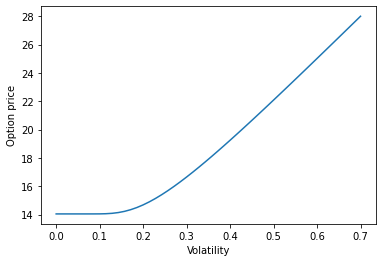

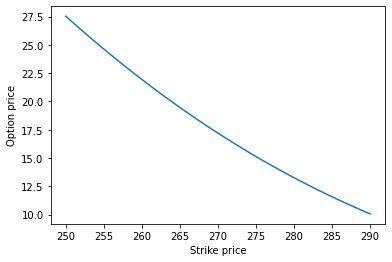

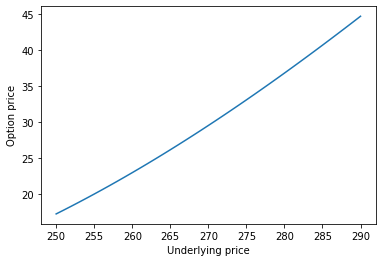

In [7]:
plt.plot(expiry_time_range, expiry_time_effect)
plt.xlabel('Expiry time in days')
plt.ylabel('Option price')
plt.show()

plt.plot(volatility_range, volatility_effect)
plt.xlabel('Volatility')
plt.ylabel('Option price')
plt.show()

plt.plot(strike_range, strike_effect)
plt.xlabel('Strike price')
plt.ylabel('Option price')
plt.show()

plt.plot(underlying_price_range, underlying_price_effect)
plt.xlabel('Underlying price')
plt.ylabel('Option price')
plt.show()


<b>Monte Carlo simulation for a vanilla option;</b> In this case we simulate the price of the underlying by multiplying it with a random sample from a normal distribution. We only consider simulated paths where the price is above the strike price $K$ otherwise it would be equally economical or better to buy the underlying at the expiry of the contract. The difference of the stock price and the strike price gives us a contract price for that simulation. The average of all simulations would give us a more realistic option price, should the stock have evolved differently. This method can be used to test for other uncertainty in the underlying, or other more complicated features.

In [8]:
simulated_option_prices = []
simulations = int(1e5)
for i in range(simulations):
    sim_price = S * np.exp(r * dt - .5 * np.power(sigma,2) * dt + sigma * np.random.randn() * np.sqrt(dt))
    simulated_option_prices.append((sim_price - K) * np.where(sim_price > K, 1, 0) * np.exp(-r))

In [9]:
mc_C = pd.Series(simulated_option_prices).mean()
print("Monte Carlo simulated option price:", np.round(mc_C, round_dec), " Single run option price:", np.round(C, round_dec))

Monte Carlo simulated option price: 26.1432  Single run option price: 26.3505


The value of the option largely depends on the future realised price volatility of the underlying or $C=f(\sigma,\cdot)$. $f$ would be monotonically increasing in $\sigma$ - higher volatility gives a higher option price. Meaning there could be a inverse function $f^{-1}$ which could produce the volatility $\sigma$ given an option price $C$.

The value $\sigma_{\bar{C}}$ is the volatility implied by the market price $\bar{C}$. <b>Implied Volatility</b> can be computed by recalculating the option value for varying volatility (and all other input parameters fixed) until we find a value closest to the input within some tolerance $\epsilon$. $1_A(\sigma) =
    \begin{cases}
      1 & \text{if $(\bar{C} - f(\sigma,\cdot)) < \epsilon$}\\
      0 & \text{otherwise}
    \end{cases}$; The set $A$ is subset of the set of all volatility values that we want to run for - $V$, such that they generate an option price within $\epsilon$ tolerance of our option price $\bar{C}$.
<br>Note, there is only one implied volatility if our test space is continuous and $\epsilon = 0$. In the discrete case we approximate the implied volatility given our tolerance threshold.

In [10]:
def call_implied_vol(C, S, K, r, dt, tol, n):
    for sigma in np.linspace(0, 1, n): #n is the cardinality of set V above
        if (C - call(S, K, r, dt, sigma)) < tol:
            return sigma
    return None

In [11]:
tol, n = 1e-4, int(1e4)
print("Actual vol:",np.round(sigma, round_dec), " Implied vol:", np.round(call_implied_vol(C, S, K, r, dt, tol, n), round_dec))

<ipython-input-2-f5ebf365f591>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.log(S/K) + (r + np.sqrt(sigma) * .5 * dt)) / (sigma * np.sqrt(dt))


Actual vol: 0.6447  Implied vol: 0.6448


Besides the volatility, it is important to understand how all other input parameters impact the price. Few cells above I have plotted the relation of input variables and option price, but a mathematical derivation can also be given. In the finance vocabulary, these are called <b>the Greeks or the 4 factors for measuring risk in the option contract.</b>

<b>Delta:</b> The sensitivity of the option price change relative to the change of the underlying's price. $\Delta = \frac{\partial{C}}{\partial{S}}$ <br> Without showing the derivative, we can evaluate the main equation in relative changes. For a small change in $S$, $d_1$ and $d_2$ would not change much given they only compute $ln_K^S$. The term $SN(d_1)$ represents the value of the expected option price at expiration and it is directly impacted by $\Delta S$. If $S$ goes up, $SN(d_1)$ would go up relatively equal as $S$ and the second term in the equation will remain roughly the same if we discount the minor impact on $d_2$. So, we can conclude that: $\Delta = N(d_1)$

In [12]:
def call_delta(S, K, r, dt, sigma):
    return norm.cdf(d1(S, K, r, dt, sigma))
print("Delta:", np.round(call_delta(S, K, r, dt, sigma), round_dec))

Delta: 0.7446


<b>Gamma:</b> Measures the rate of change in the delta with respect to changes in the underlying price. That is basically the second derivative of the function with respect to $S$. $\Gamma = \frac {\partial \Delta} {\partial S} = \frac {\partial^2 C} {\partial S^2}$ The derivative of the CDF of $d_1$ would be the PDF of $d_1$ and in the denominator we are left with $S \sigma \sqrt{\Delta t}$ or $\Gamma = \frac {N'(d_1)} {S \sigma \sqrt{\Delta t}}$.

In [13]:
def call_gamma(S, K, r, dt, sigma):
    return norm.pdf(d1(S, K, r, dt, sigma)) / (S * sigma * np.sqrt(dt))
print("Gamma:", np.round(call_gamma(S, K, r, dt, sigma), round_dec))

Gamma: 0.0065


<b>Vega:</b> Measures the sensitivity to volatility. Derivative of the option value with respect to the volatility of the underlying: $\nu = \frac {\partial C} {\partial \sigma} = SN'(d_1)\sqrt \Delta t$

In [14]:
def call_vega(S, K, r, dt, sigma):
    return S * norm.pdf(d1(S, K, r, dt, sigma)) * np.sqrt(dt) * 0.01
print("Vega:", np.round(call_vega(S, K, r, dt, sigma), round_dec))

Vega: 0.2461


<b>Theta:</b> Measures the sensitivity of the option value to the maturity time (time decay): $\Theta = \frac {\partial C}{\partial t}$. The risk of passing time represents loss of the value of an option (decay) hence theta is expressed as a negative figure. The derivation of this is quite mathematically involved, so in the calculation below I will only put the final result or $\Theta = - \frac {SN'(d_1)\sigma} {2\sqrt{\Delta t}} - rKe^{-r\Delta t}N(d_2)$:

In [15]:
def call_theta(S, K, r, dt, sigma):
    dd1 = -(S * norm.pdf(d1(S, K, r, dt, sigma)) * sigma) / (2 * np.sqrt(dt))
    dd2 = r * K * np.exp(-r * dt) * norm.cdf(d2(S, K, r, dt, sigma))
    return (dd1 - dd2) * 0.01
print("Theta:", np.round(call_theta(S, K, r, dt, sigma), round_dec))

Theta: -1.0163
